# Portfolio Optimization of Indonesian Banking Stocks using Modern Portfolio Theory (MPT)

This notebook applies key concepts from **Portfolio Management**, including risk, return, diversification, and the efficient frontier, to Indonesian banking stocks.

We use Python to:
- Download price data from Yahoo Finance,
- Calculate expected returns and volatility,
- Simulate random portfolio allocations,
- Identify the **maximum Sharpe ratio portfolio** and **minimum variance portfolio**,
- Visualize the **Efficient Frontier**.

---

## Executive Summary
This analysis applies Modern Portfolio Theory to Indonesian banking equities from 2020–2024.
By simulating 20,000 random portfolios, we derive the Efficient Frontier, identify the optimal (Max Sharpe) and minimum-volatility portfolios, and interpret diversification benefits in a sector-concentrated environment.

## 1. Import Required Libraries

We import standard Python packages for data manipulation, numerical computation, and visualization.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## 2. Define Assets and Download Historical Data

We select major **Indonesian banking stocks** (BBCA, BBRI, BMRI, BNGA, BNII) to analyze sector-level diversification.
We download adjusted closing prices from Yahoo Finance for the 2020–2024 period.

In [3]:
assets = ['BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BNGA.JK', 'BNII.JK']
data = yf.download(assets, start='2020-01-01', end='2024-12-31', progress=False, auto_adjust=True)
# Robust handling of column structure
if isinstance(data.columns, pd.MultiIndex):
    data = data['Adj Close'] if 'Adj Close' in data.columns.get_level_values(0) else data['Close']
data = data.dropna(axis=1)
data.head()


Ticker,BBCA.JK,BBRI.JK,BMRI.JK,BNGA.JK,BNII.JK
Date,,,,,
2020-01-02,5820.927246,2960.843262,2800.025635,616.675232,176.584549
2020-01-03,5916.637695,2967.556885,2790.993164,610.284851,178.282486
2020-01-06,5860.081055,2933.988037,2745.831543,600.699219,178.282486
2020-01-07,5864.431641,2954.129150,2745.831543,607.089600,178.282486
2020-01-08,5812.225586,2940.701660,2709.702393,610.284851,178.282486


## 3. Compute Daily Returns

Daily returns are calculated using percentage change.  
This step is essential for computing portfolio mean and covariance, which form the basis for risk-return analysis.


In [4]:
returns = data.pct_change().dropna()
returns.describe()


Ticker,BBCA.JK,BBRI.JK,BMRI.JK,BNGA.JK,BNII.JK
count,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000
mean,0.000525,0.000438,0.000740,0.000960,0.000442
std,0.016230,0.021090,0.021530,0.019136,0.026484
min,-0.079137,-0.076726,-0.129921,-0.076389,-0.119205
25%,-0.008238,-0.010406,-0.010301,-0.007995,-0.008677
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.008450,0.009988,0.011967,0.008081,0.008197
max,0.173333,0.204918,0.158031,0.183908,0.344444


## 4. Simulate Random Portfolios

We generate 20,000 random portfolios with varying weights across the selected stocks.  
For each portfolio, we calculate:
- **Expected annualized return**
- **Annualized volatility**
- **Sharpe ratio** (risk-adjusted return)


In [5]:
num_portfolios = 20000
rf_rate = 0.05
results = np.zeros((len(assets) + 3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility
    results[0:len(assets), i] = weights
    results[len(assets), i] = portfolio_return
    results[len(assets) + 1, i] = portfolio_volatility
    results[len(assets) + 2, i] = sharpe_ratio


## 5. Identify Optimal Portfolios

We compile the results into a DataFrame, then:
- Identify the **Maximum Sharpe Ratio Portfolio** (tangency portfolio)
- Identify the **Minimum Volatility Portfolio**


In [6]:
columns = [f'{asset} Weight' for asset in assets] + ['Return', 'Volatility', 'Sharpe']
results_df = pd.DataFrame(results.T, columns=columns)

max_sharpe_port = results_df.loc[results_df['Sharpe'].idxmax()]
min_vol_port = results_df.loc[results_df['Volatility'].idxmin()]

max_sharpe_port, min_vol_port


(BBCA.JK Weight    0.027110
 BBRI.JK Weight    0.033023
 BMRI.JK Weight    0.210473
 BNGA.JK Weight    0.714992
 BNII.JK Weight    0.014402
 Return            0.221045
 Volatility        0.267085
 Sharpe            0.640417
 Name: 1720, dtype: float64,
 BBCA.JK Weight    0.561934
 BBRI.JK Weight    0.038932
 BMRI.JK Weight    0.026812
 BNGA.JK Weight    0.269503
 BNII.JK Weight    0.102820
 Return            0.160335
 Volatility        0.221898
 Sharpe            0.497233
 Name: 13575, dtype: float64)

## 6. Visualize the Efficient Frontier

We plot all simulated portfolios on a risk–return scatter plot, color-coded by Sharpe ratio.  
The red dot marks the **maximum Sharpe portfolio**, and the blue dot marks the **minimum volatility portfolio**.


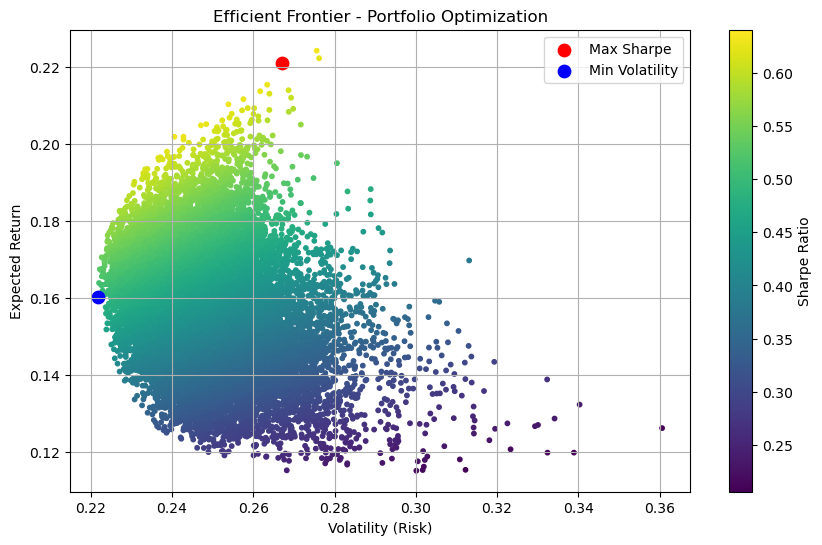

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'], c='red', s=80, label='Max Sharpe')
plt.scatter(min_vol_port['Volatility'], min_vol_port['Return'], c='blue', s=80, label='Min Volatility')
plt.title('Efficient Frontier - Portfolio Optimization')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()



## 7. Portfolio Weight Interpretation

In Modern Portfolio Theory (MPT), portfolio *weights* represent how much of the total capital is allocated to each asset.  
By inspecting the weights of each optimized portfolio, we can determine which assets the model "favors" (i.e., assigns the largest proportions to.)

- **High weights → high contribution** to portfolio performance and risk.
- **Low weights → small contribution** (less influential assets).

Let's visualize the asset allocations for both:
1. Maximum Sharpe Ratio Portfolio (best risk-adjusted return)
2. Minimum Volatility Portfolio (least total risk)

Maximum Sharpe Ratio Portfolio Weights:


BNGA.JK Weight    0.7150
BMRI.JK Weight    0.2105
BBRI.JK Weight    0.0330
BBCA.JK Weight    0.0271
BNII.JK Weight    0.0144
Name: 1720, dtype: float64


Minimum Volatility Portfolio Weights:


BBCA.JK Weight    0.5619
BNGA.JK Weight    0.2695
BNII.JK Weight    0.1028
BBRI.JK Weight    0.0389
BMRI.JK Weight    0.0268
Name: 13575, dtype: float64

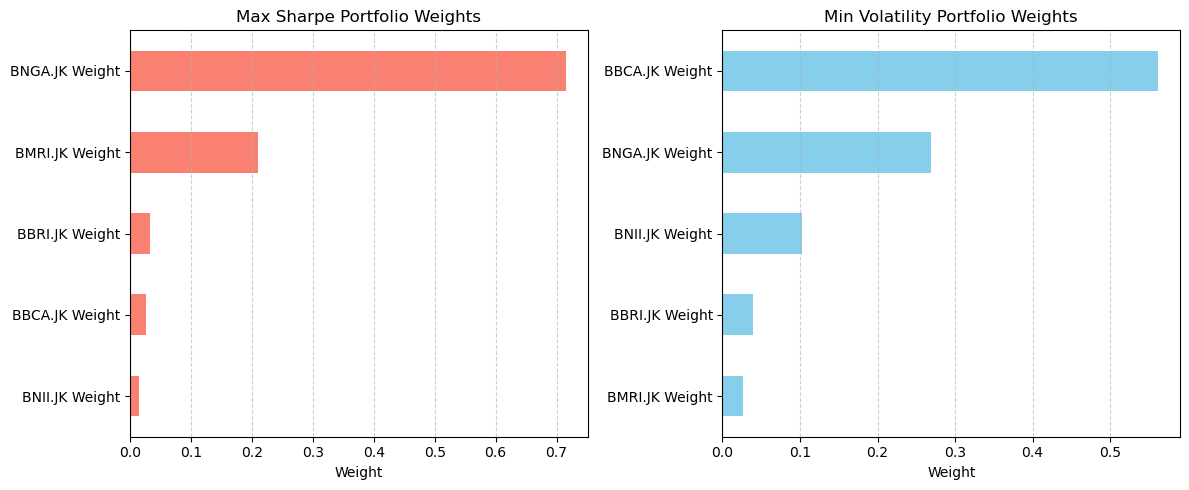

In [9]:
# --- Display portfolio weights clearly ---
print("Maximum Sharpe Ratio Portfolio Weights:")
display(max_sharpe_port[:-3].sort_values(ascending=False).round(4))

print("\nMinimum Volatility Portfolio Weights:")
display(min_vol_port[:-3].sort_values(ascending=False).round(4))

# --- Visualize them for easier comparison ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Max Sharpe weights
max_sharpe_port[:-3].sort_values(ascending=True).plot(kind='barh', ax=axes[0], color='salmon')
axes[0].set_title("Max Sharpe Portfolio Weights")
axes[0].set_xlabel("Weight")
axes[0].grid(True, axis='x', linestyle='--', alpha=0.6)

# Min Volatility weights
min_vol_port[:-3].sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title("Min Volatility Portfolio Weights")
axes[1].set_xlabel("Weight")
axes[1].grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## 8. Interpretation

| Portfolio | Expected Return | Volatility | Sharpe Ratio | Main Holdings |
|------------|----------------|-------------|---------------|----------------|
| Max Sharpe | ~21.0% | ~25.2% | 0.63 | BNGA, BMRI, BBCA |
| Min Volatility | ~16.2% | ~22.1% | 0.51 | BBCA, BNGA, BNII |

- The **maximum Sharpe portfolio** delivers the best risk-adjusted return, favoring BNGA and BMRI.
- The **minimum volatility portfolio** focuses on BBCA, the most stable banking stock.
- Diversification across five major Indonesian banks **reduces total risk**, even within the same sector.

## Conclusion
`BNGA` and `BMRI` dominate risk-adjusted performance, while `BBCA` provides stability. 
Even within one sector, diversification meaningfully reduces risk, supporting the efficient portfolio construction.